In [1]:
import os
import sys
from datetime import datetime
from os.path import abspath
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt

yf.pdr_override()

from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar

from zipline.api import set_max_leverage, schedule_function, set_benchmark,set_commission
from zipline.finance.commission import PerContract, PerDollar, PerShare, PerTrade
from zipline.finance.commission import CommissionModel
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
from zipline.finance.commission import PerShare, PerTrade, PerDollar
from zipline.api import set_slippage, set_commission
from zipline.data.bundles import register, unregister, ingest
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar
from zipline.api import (order, 
                         order_target,
                         order_value,
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, date_rules, time_rules, symbol # type: ignore


import quantstats as qs
import warnings
warnings.filterwarnings('ignore', category=Warning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
%matplotlib inline
%load_ext autoreload
%autoreload 2

ROOT_DIR = abspath('../')
sys.path.append(ROOT_DIR)

In [2]:
START_DATE = pd.Timestamp('2018-01-01')
END_DATE = pd.Timestamp('2023-01-01')

BASE_CAPITAL = 100_000

def calculate_years() -> int:
    return int((END_DATE - START_DATE).days / 365)

YEARS = calculate_years()

In [3]:
def plots(results):
    start = results.index[0]
    end = results.index[-1]
    benchmark = pdr.get_data_yahoo('^GSPC', start=start, end=end)['Adj Close'].pct_change()
    results.index = pd.to_datetime(results.index).tz_convert(None)
    results.index = benchmark.index  
    qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4))

In [4]:
parquet_file_path = f"{ROOT_DIR}/data/clusters/adf_cluster_{YEARS}y.parquet"
data = pd.read_parquet(parquet_file_path)
data = data.iloc[:, 0].tolist()

In [5]:
def rebalance_static(context, data):
    for stocks in context.portfolio.positions:
        current_price = data.current(stocks, 'price')
        cost_basis = context.portfolio.positions[stocks].cost_basis
        amount = context.portfolio.positions[stocks].amount

        if amount > 0:
            if current_price * (1 + context.take_profit) > cost_basis:
                order_target_percent(stocks, 0)
                context.profits += 1
            elif current_price * (1 - context.stop_loss) < cost_basis:
                order_target_percent(stocks, 0)
                context.stops += 1
        elif amount < 0:
            if  current_price * (1 - context.take_profit) < cost_basis:
                order_target_percent(stocks, 0)
                context.profits += 1
            elif current_price * (1 + context.stop_loss) > cost_basis:
                order_target_percent(stocks, 0)
                context.stops += 1

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-01-31   2018-01-31
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       99.0%

Cumulative Return          36.04%       72.0%
CAGR﹪                     4.42%        7.92%

Sharpe                     0.4          0.49
Prob. Sharpe Ratio         80.77%       86.69%
Smart Sharpe               0.32         0.4
Sortino                    0.54         0.75
Smart Sortino              0.44         0.6
Sortino/√2                 0.38         0.53
Smart Sortino/√2           0.31         0.42
Omega                      1.14         1.14

Max Drawdown               -33.92%      -59.3%
Longest DD Days            361          273
Volatility (ann.)          22.0%        34.25%
R^2                        0.57         0.57
Information Ratio          0.02         0.02
Calmar                   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-12,2020-03-23,2020-11-10,273,-59.299690,-47.727775
2,2022-09-13,2022-10-12,2022-12-30,109,-20.535283,-20.498883
3,2018-11-09,2018-12-24,2019-01-16,69,-17.241777,-13.630106
4,2019-04-08,2019-05-31,2019-10-10,186,-15.430626,-14.588657
5,2022-05-31,2022-06-17,2022-07-28,59,-12.516479,-12.045451


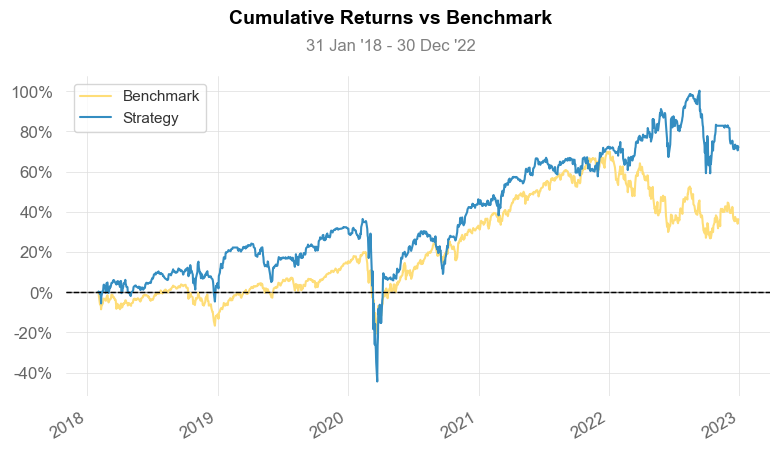

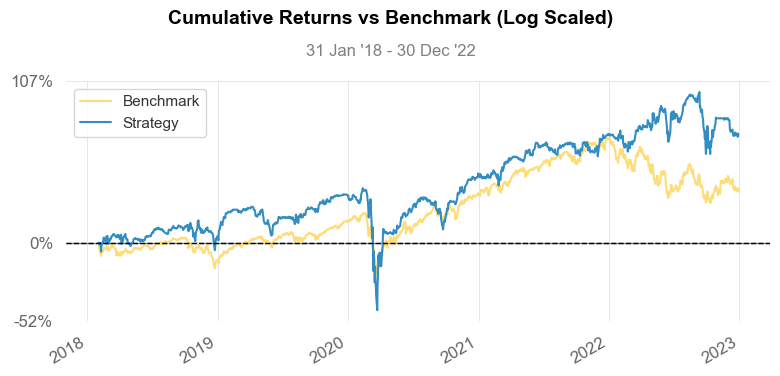

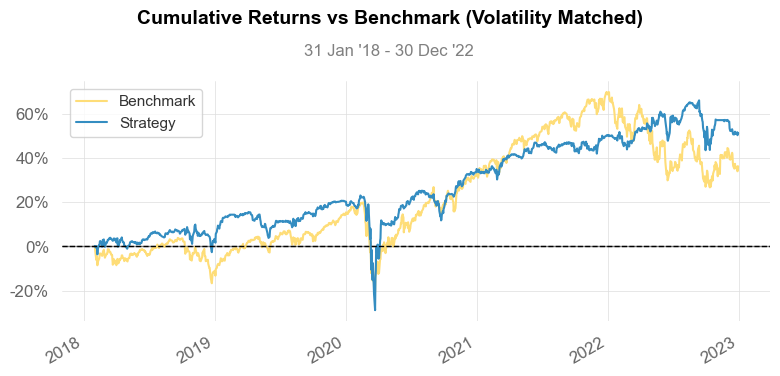

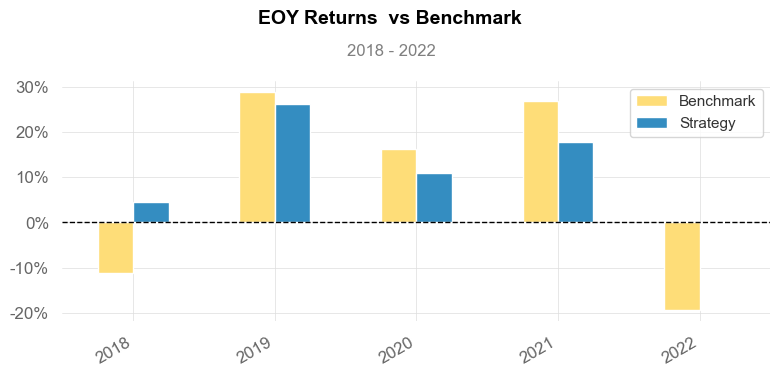

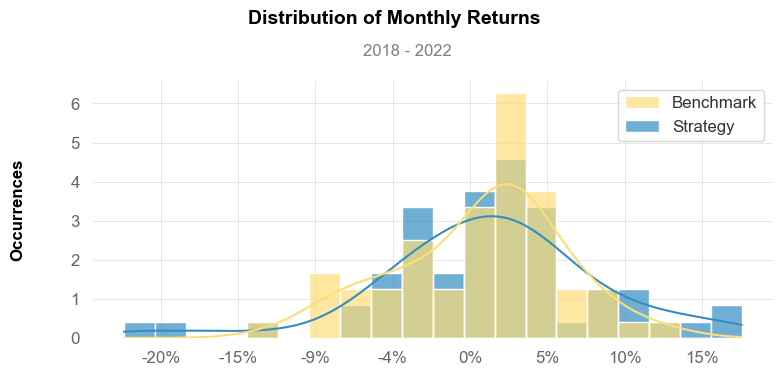

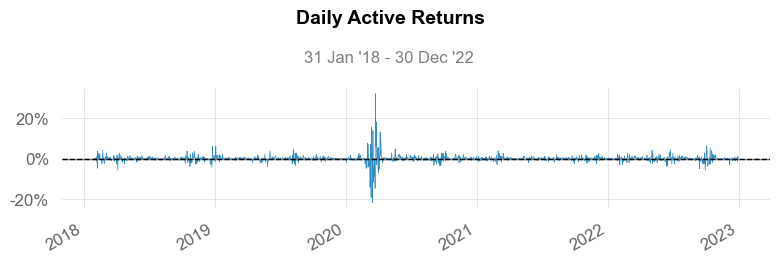

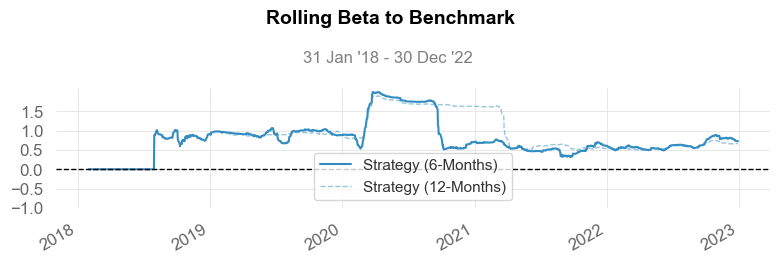

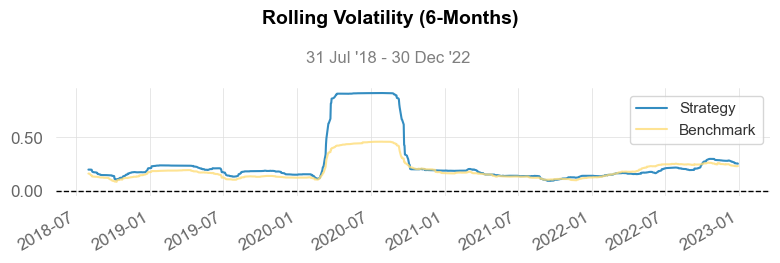

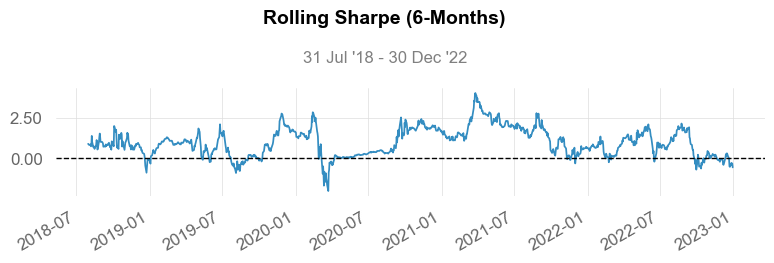

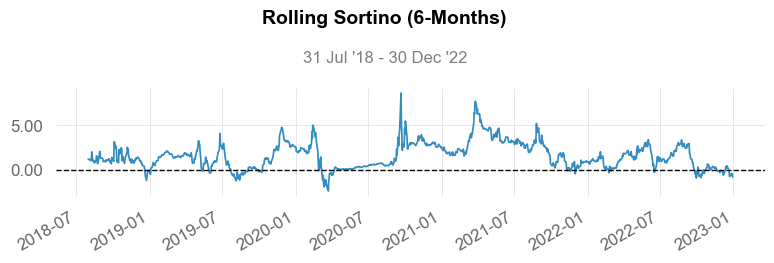

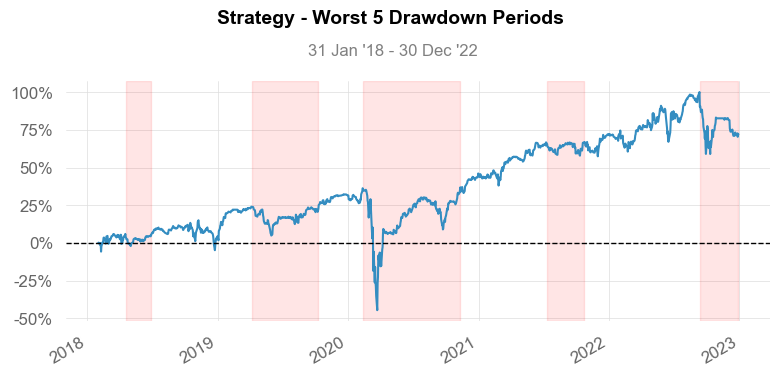

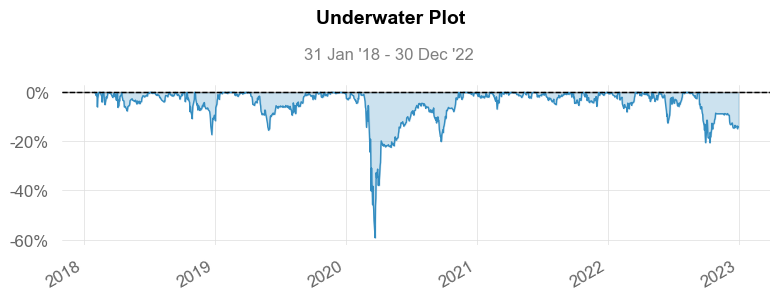

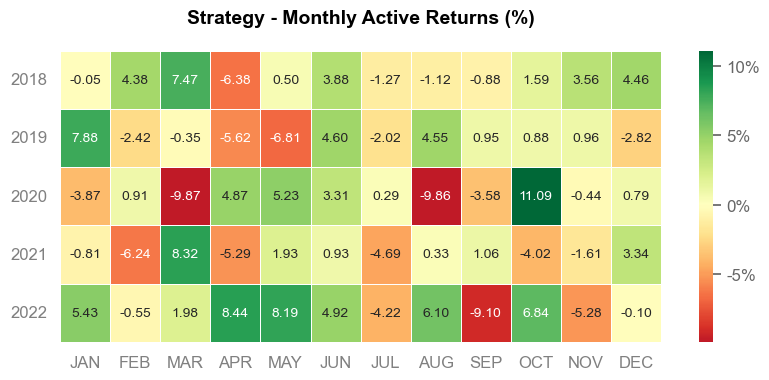

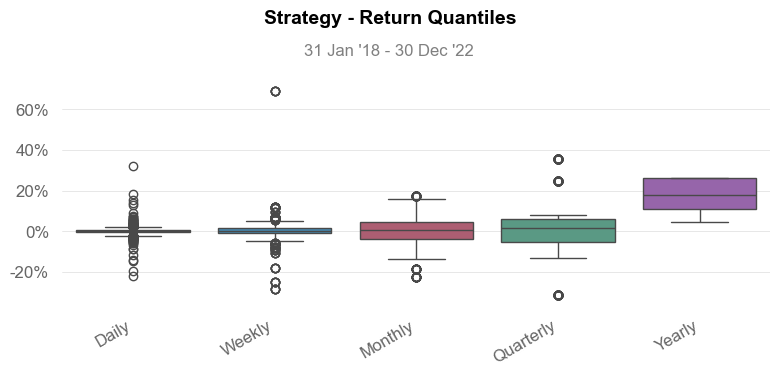

In [6]:
def initialize(context):
    context.idx = 0
    context.tickers = data
    context.bollinger_window = 20
    context.bollinger_dev = 1.5
    context.stop_loss, context.take_profit  = 0.05, 0.05
    context.stops, context.profits = 0, 0
    context.buy_stocks = set()
    
    set_commission(PerShare(cost=0.003))
    set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))

def handle_data(context, data):
    context.idx += 1
    if context.idx < context.bollinger_window:
        return

    for ticker in context.tickers:
        # Get historical price data using data.history
        prices = data.history(symbol(ticker), 'price', context.bollinger_window + 1, '1d')

        # Calculate Bollinger Bands
        sma = prices.mean()
        rolling_std = prices.std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)

        current_price = data.current(symbol(ticker), 'price')
        # cost_basis = context.portfolio.positions[symbol(ticker)].cost_basis
        # amount = context.portfolio.positions[symbol(ticker)].amount
        
        # print(context)

        # Calculate stop-loss and take-profit levels
        stop_loss_price = current_price * (1 - context.stop_loss)
        take_profit_price = current_price * (1 + context.take_profit)

        # Generate signals based on Bollinger Bands, stop-loss, and take-profit
        if current_price < lower_band and ticker not in context.buy_stocks:
            order_target_percent(symbol(ticker), 0.2)  # Buy
            context.buy_stocks.add(ticker)
        elif current_price > upper_band and ticker in context.buy_stocks:
            order_target_percent(symbol(ticker), 0)  # Sell
            context.buy_stocks.remove(ticker)
        
        rebalance_static(context, data)
                
        # Record the values for later analysis
        record(
            price=current_price,
            mid=sma,
            upper=upper_band,
            lower=lower_band,
            stop_loss=stop_loss_price,
            take_profit=take_profit_price
        )
        
# Run the algorithm
results = run_algorithm(
    start=START_DATE,
    end=END_DATE,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=BASE_CAPITAL,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='sp500bundle',
)
plots(results)